# Task 1: Supervised contrastive loss on any small dataset  

> Aryan Garg    


#### Dataset Used: CIFAR-10 (4%)

## Imports 

### wandb

In [ ]:
try:
  import wandb
  from pytorch_lightning.loggers import WandbLogger
except:
  !pip -qqq install wandb pytorch-lightning torchmetrics > /dev/null
  import wandb
  from pytorch_lightning.loggers import WandbLogger

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Lightning

In [ ]:
try:
  import lightning.pytorch as pl
except:
  print("[!] Couldn't find pytorch-lightning.\nInstalling it...\n")
  !pip install lightning > /dev/null
  import lightning.pytorch as pl

[!] Couldn't find pytorch-lightning.
Installing it...



In [ ]:
from lightning.pytorch.utilities.model_summary import ModelSummary
from pytorch_lightning import seed_everything

### Standard Imports

In [ ]:
import os
import shutil
import pathlib
import copy
import time
import random
import math

# Imaging & Viz Libs
from PIL import Image, ImageEnhance, ImageOps
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2 as cv

# Core libs
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm

# Torch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.optim import lr_scheduler
from torch.cuda import amp

from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets
from torchvision.utils import make_grid
import torchvision.transforms as T

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, f1_score

# Albumentations for augs
from collections import defaultdict
try:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
except:
  print("[!] Couldn't find albumentations... installing it...")
  !pip install -U albumentations > /dev/null
  import albumentations as A
  from albumentations.pytorch import ToTensorV2

# timm :)
try:
  import timm
  from pytorch_metric_learning import losses
except:
  print(f"Installing timm pytorch-metric-learning")
  !pip install -q timm pytorch-metric-learning > /dev/null
  import timm
  from pytorch_metric_learning import losses

Installing timm pytorch-metric-learning


## (Custom) Utilities

In [ ]:
# Folder Utilities ----------------------------

## Create dir if it doesn't exist
def create_dir(dir_name):
  if not os.path.exists(f'/content/{dir_name}'):
    os.mkdir(f'/content/{dir_name}')

## Delete dir: checkpoints
def delete_dir(dir_name):
  if os.path.isdir(f'/content/{dir_name}'):
    shutil.rmtree(f'/content/{dir_name}')

# ---------------------------------------------
create_dir("checkpoints")

## Configurations & Devices

In [ ]:
CONFIG = {'seed': 42, 
          'model_name': 'tf_efficientnet_b4_ns',
          'img_size': 32,
          'scheduler' : 'CosineAnnealingLR', 
          'T_max' : 10,
          'lr' : 1e-4, 
          'min_lr' : 1e-6,
          'batch_size' : 4,
          'weight_decay' : 1e-6,
          'num_epochs' : 10,
          'num_classes' : 10,
          'embedding_size' : 2048,
          'n_accumulate' : 4,
          'temperature' : 0.7,
          'checkpoint_path' : '/content/checkpoints',
          'auto_aug': False
          }

In [ ]:
seed_everything(CONFIG['seed'])

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [ ]:
# device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

## Transforms

## DuplicateSampleTransform

In [ ]:
class DuplicateSampleTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        """
        sample == torch.DataLoader item
        returns -> (torch.Tensor, torch.Tensor)
        """
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj

### Create the transforms

In [ ]:
# Statistics of CIFAR-10:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Train Transform
transform_train = [T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(),]

if CONFIG['auto_aug']: # Use pytorch inbuilt (class above can be used if this fails)
  transform_train.append(T.AutoAugment(T.AutoAugmentPolicy.CIFAR10))

transform_train.extend([T.ToTensor(), T.Normalize(mean, std),])

transform_train = T.Compose(transform_train)

# For stage 1 training: 2N samples
train_contrastive_transform = DuplicateSampleTransform(transform_train)

# Test transforms
transform_test = T.Compose([T.ToTensor(), T.Normalize(mean, std),])

## Dataset & DataLoader

In [ ]:
trainset_contrastive = torchvision.datasets.CIFAR10(root='/content/cont_data', train=True,
                                        download=True, transform=train_contrastive_transform)

trainset = torchvision.datasets.CIFAR10(root='/content/data', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='/content/data', train=False,
                                       download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:01<00:00, 87492297.23it/s]


Extracting /content/cont_data/cifar-10-python.tar.gz to /content/cont_data


100%|██████████| 170498071/170498071 [00:02<00:00, 84858298.84it/s]


Extracting /content/data/cifar-10-python.tar.gz to /content/data
Files already downloaded and verified


In [ ]:
len(trainset), len(testset), len(trainset_contrastive)

(50000, 10000, 50000)

In [ ]:

# ****
# WARNING: Cell takes about 2-3 minutes to execute
# ****

# 4% train data, 5% test data

%time

def subset_dataset(dataset: torchvision.datasets, per_class_samples = 200):
  cnt_class = np.zeros(10)
  indices_lst = []
  for i in range(len(dataset)):
    _, label = dataset[i]
    if cnt_class[label] < per_class_samples:
      indices_lst.append(i)
      cnt_class[label] += 1

  small_ds = torch.utils.data.Subset(dataset, indices_lst)

  return small_ds 


small_trainset = subset_dataset(trainset, 500)
small_testset = subset_dataset(trainset, 100) # 4:1 ratio or 80:20 split
small_trainset_contrastive = subset_dataset(trainset_contrastive, 500)

# 200 per class == 2000 images' dataset

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [ ]:
# torch.save(small_trainset, 's_trainset.pt')
# torch.save(small_testset, 's_testset.pt')
# torch.save(small_trainset_contrastive, 's_trainset_contrastive.pt')

In [ ]:
trainloader = DataLoader(small_trainset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)

testloader = DataLoader(small_testset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

trainloader_contrastive = DataLoader(small_trainset_contrastive, batch_size=CONFIG['batch_size'], shuffle=True)

## Sanity Visualizations

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

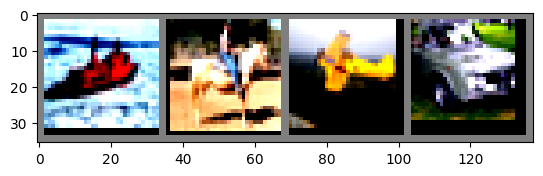

ship  horse plane car  


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(CONFIG['batch_size'])))

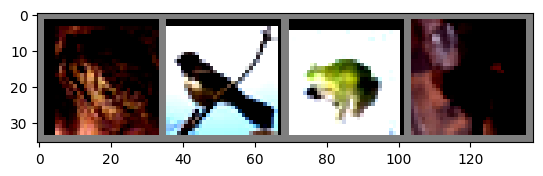

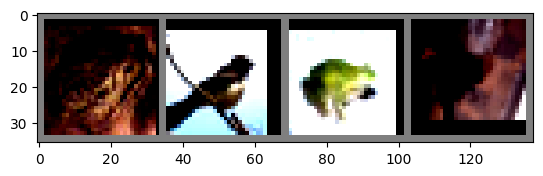

['frog', 'bird', 'frog', 'cat']


In [ ]:
imgs, label = next(iter(trainloader_contrastive))
imgs_1, imgs_2 = imgs
imshow(make_grid(imgs_1))
imshow(make_grid(imgs_2))
print([classes[i] for i in label])

## Model Archs

### Projector Net

In [ ]:
class ProjectorNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(CONFIG['embedding_size'], 128)

  def forward(self, x):
    out = self.linear(x)
    return out

### Classifier Net

In [ ]:
class ClassifierNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential([
        nn.Linear(CONFIG['embedding_size'], 1000), # as per paper 
        nn.ReLU(inplace=True),
        nn.Linear(1000, CONFIG['num_classes']) # will treat output as logits!
        ])

  def forward(self, x):
    out = self.model(x)
    return out

## SupCon Loss

In [ ]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, feature_vectors, labels):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )
        return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

## Lightning Recipe

In [ ]:
class LIT_SupCon(pl.LightningModule):
  def __init__(self, model, projector=None, classifier=None, isContrastive=True):
    super().__init__()

    self.save_hyperparameters(ignore=[projector, model, classifier])
    self.automatic_optimization = False

    self.model = model

    self.isContrastive = isContrastive

    if self.isContrastive:
      assert projector is not None, "Please pass in a projector network"
      self.projector = projector
      self.criterion = SupervisedContrastiveLoss(temperature=CONFIG['temperature']).to(device)
    else:
      assert classifier is not None, "Please pass in a classifier layer to train"
      self.criterion = nn.CrossEntropyLoss().to(device)
      self.classifier = classifier
      for param in self.model.parameters():
        param.requires_grad = False
    
  
  def configure_optimizers(self):
    optimizer = optim.Adam(self.model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])
    return [optimizer], [scheduler]

  def forward(self):
    pass

  def test_step(self, batch, batch_idx):
    imgs, targets = batch
    
    embeddings = self.model(imgs)
    outputs = self.classifier(embeddings)

    test_loss = self.criterion(outputs, targets)

    predictions = torch.argmax(outputs, dim = 1) 
    # print("preds, targets:", predictions, targets)
    tp_count = (predictions == targets).sum()

    self.log_dict({"CE_loss_test": test_loss, "Acc_test": 100. *  tp_count / len(targets)}, 
                    on_step=True, on_epoch=True, prog_bar=True, logger=True)
    

  def training_step(self, batch, batch_idx):
    opt = self.optimizers()
    sch = self.lr_schedulers()

    if self.isContrastive: # stage 1 training -- contrastive loss on embedding space
      imgs, labels = batch

      inputs = torch.cat(imgs)
      targets = labels.repeat(2)
      # print(inputs.shape, inputs.device, targets.shape, targets.device)
      # print(f"Labels: {targets}")
      embeddings = self.model(inputs)
      outputs = self.projector(embeddings)

    else: # stage 2 training -- classifier
      imgs, targets = batch
      embeddings = self.model(imgs)
      
      outputs = self.classifier(embeddings) # here projector is the classifier layer (#num_classes, input_embedding_dims)
    
    loss = self.criterion(outputs, targets)

    self.manual_backward(loss)
    opt.step()
    opt.zero_grad()

    if (batch_idx + 1) % CONFIG['batch_size'] == 0:
      sch.step()

    # self.logger.experiment.log({"Gen_Image_1 (during training)":[wandb.Image(fake_imgs[gen_id].cpu(), caption="Generated (train_step)")]})
    if self.isContrastive:
      self.log_dict({"SupCon_loss": loss}, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    else:
      # outputs = outputs.detach()
      predictions = torch.argmax(outputs, dim = 1) 
      # print("preds, targets:", predictions, targets)
      tp_count = (predictions == targets).sum()

      self.log_dict({"CE_loss": loss, "Acc": 100. *  tp_count / len(targets)}, 
                    on_step=True, on_epoch=True, prog_bar=True, logger=True)
    
        

In [ ]:
# init: Model performance & acc :: Efficient_Net_b4 > resNet-50
model = timm.create_model(CONFIG['model_name'], pretrained=True)

# classifier == Projector Network right now -- stage 1
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, CONFIG['embedding_size'])    

projector = ProjectorNet() # Projector will be discarded in stage 2
# Dummy pass:
out = model(torch.randn(4, 3, CONFIG['img_size'], CONFIG['img_size']))
pr_out = projector(out)

print(f'Embedding shape: {out.shape} | Projected Embedding shape: {pr_out.shape}')

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


Embedding shape: torch.Size([4, 2048]) | Projected Embedding shape: torch.Size([4, 128])


In [ ]:
classifier = ClassifierNet()

TypeError: ignored

In [ ]:
sup = LIT_SupCon(model, projector, classifier, isContrastive=True)

summary = ModelSummary(sup, max_depth=-1)
# print(summary)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(


## Trainer (+ Callbacks & Logger) 

In [ ]:
from pytorch_lightning import Callback
from lightning.pytorch.callbacks import DeviceStatsMonitor, TQDMProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Checkpoint
checkpoint_callback = ModelCheckpoint(dirpath=CONFIG['checkpoint_path'],
                                      filename='{epoch}-{SupCon_loss:.3f}',
                                      monitor='SupCon_loss', # Need to change this everytime
                                      save_top_k=5,
                                      save_last=True,
                                      save_weights_only=True,
                                      verbose=True,
                                      mode='min')

# Exp2: Learning Rate Monitor
lr_monitor = LearningRateMonitor(logging_interval='step', log_momentum=True)

# Earlystopping
# earlystopping = EarlyStopping(monitor='val_acc', patience=3, mode='min')

In [ ]:
wandb_logger = WandbLogger(project='Supervised_Contrastive', 
                           name='exp-2_No_AutoAug_10perc',
                           config=CONFIG,
                           job_type='train',
                           log_model="all")

wandb: Currently logged in as: aryangarg019. Use `wandb login --relogin` to force relogin


In [ ]:
trainer = pl.Trainer(fast_dev_run=False,    # For debugging purposes
                     log_every_n_steps=1,   # set the logging frequency
                     accelerator='auto',    # Precedence: tpu > gpu >> cpu
                     devices="auto",        # all
                     max_epochs=CONFIG['num_epochs'], # number of epochs
                     callbacks=[TQDMProgressBar(refresh_rate=25), 
                                checkpoint_callback, 
                                lr_monitor],
                     logger=wandb_logger,    # wandb <3
                     )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training Stage 1 

In [ ]:
trainer.fit(sup, trainloader_contrastive)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | EfficientNet              | 21.2 M
1 | projector | ProjectorNet              | 262 K 
2 | criterion | SupervisedContrastiveLoss | 0     
--------------------------------------------------------
21.5 M    Trainable params
0         Non-trainable params
21.5 M    Total params
85.932    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | EfficientNet              | 21.2 M
1 | projector | ProjectorNet              | 262 K 
2 | criterion | SupervisedContrastiveLoss | 0     
--------------------------------------------------------
21.5 M    Trainable params
0         Non-trainab

Training: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 1250: 'SupCon_loss' reached 3.62325 (best 3.62325), saving model to '/content/checkpoints/epoch=0-SupCon_loss=3.623.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 1250: 'SupCon_loss' reached 3.62325 (best 3.62325), saving model to '/content/checkpoints/epoch=0-SupCon_loss=3.623.ckpt' as top 5
INFO: Epoch 1, global step 2500: 'SupCon_loss' reached 3.01694 (best 3.01694), saving model to '/content/checkpoints/epoch=1-SupCon_loss=3.017.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 2500: 'SupCon_loss' reached 3.01694 (best 3.01694), saving model to '/content/checkpoints/epoch=1-SupCon_loss=3.017.ckpt' as top 5
INFO: Epoch 2, global step 3750: 'SupCon_loss' reached 2.76908 (best 2.76908), saving model to '/content/checkpoints/epoch=2-SupCon_loss=2.769.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 3750: 'SupCon_loss' reached 2.76908 (best 2.76908), saving model to '/co

## Training Stage 2

### Load best weights

In [ ]:
last_ckpt = "last.ckpt"
bestEnc = LIT_SupCon.load_from_checkpoint(f"/content/checkpoints/{last_ckpt}", map_location=device)

summary = ModelSummary(bestEnc, max_depth=-1)
# print(summary)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.
  rank_zero_warn(


## t-SNE: feature embedding space visualization?

In [ ]:
print(bestEnc.model(torch.randn(4,3,32,32).to(device)).shape)
out_vec = bestEnc.model(torch.randn(4,3,32,32).to(device))
projector = projector.to(device)
print(projector(out_vec).shape)
# use this to train classifier: bestEnc.model

torch.Size([4, 2048])
torch.Size([4, 128])


In [ ]:
# import numpy as np
# from sklearn.manifold import TSNE

# X = []
# id2class = {0:'plane', 1:'car', 2:'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7:'horse', 8:'ship', 9:'truck'}

# class_cnt = {'plane': [], 'car': [], 'bird': [], 
#              'cat': [], 
#              'deer': [], 
#              'dog': [], 
#              'frog': [], 
#              'horse': [], 
#              'ship': [], 
#              'truck': []}

# itr = 0
# for i, batch in enumerate(trainloader):
#   x,y = batch
#   x = x.to(device)
#   for e in y:
#     class_cnt[id2class[int(e.cpu().numpy())]].append(itr)
#     itr += 1

#   out = projector(bestEnc.model(x))

#   for ele in out:
#     X.append(ele.detach().cpu().numpy())

# X = np.array(X)

In [ ]:
# X_embedded = TSNE(n_components=128, learning_rate='auto',method='exact', init='random', perplexity=5).fit_transform(X)
# X_embedded.shape

KeyboardInterrupt: ignored

In [ ]:
# np.save("tsne_traindata.npy", X_embedded)

### Reinit LIT_SupCon with freezed encoder model

In [ ]:
clf_lit = LIT_SupCon(bestEnc.model, projector, classifier, isContrastive=False)

summary = ModelSummary(clf_lit, max_depth=-1)
# print(summary)

### Callbacks & trainer

In [ ]:
# Checkpoint
checkpoint_callback_clf = ModelCheckpoint(dirpath=CONFIG['checkpoint_path'],
                                      filename='{epoch}-{Acc:.3f}',
                                      monitor='Acc', # Need to change this everytime
                                      save_top_k=5,
                                      save_last=True,
                                      save_weights_only=True,
                                      verbose=True,
                                      mode='max')

In [ ]:
trainer_clf = pl.Trainer(fast_dev_run=False,    # For debugging purposes
                     log_every_n_steps=1,   # set the logging frequency
                     accelerator='auto',    # Precedence: tpu > gpu >> cpu
                     devices="auto",        # all
                     max_epochs=10, # number of epochs
                     callbacks=[TQDMProgressBar(refresh_rate=25), 
                                checkpoint_callback_clf],
                     logger=wandb_logger,    # wandb <3
                     )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train classifier on single sampled train dataset

In [ ]:
trainer_clf.fit(clf_lit, trainloader)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:44: UserWarning: attribute 'classifier' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type             | Params
------------------------------------------------
0 | model      | EfficientNet     | 21.2 M
1 | criterion  | CrossEntropyLoss | 0     
2 | classifier | ClassifierNet    | 20.5 K
------------------------------------------------
20.5 K    Trainable params
21.2 M    Non-trainable params
21.2 M    Total params
84.96

Training: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 1250: 'Acc' reached 12.62000 (best 12.62000), saving model to '/content/checkpoints/epoch=0-Acc=12.620.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 1250: 'Acc' reached 12.62000 (best 12.62000), saving model to '/content/checkpoints/epoch=0-Acc=12.620.ckpt' as top 5
INFO: Epoch 1, global step 2500: 'Acc' reached 12.84000 (best 12.84000), saving model to '/content/checkpoints/epoch=1-Acc=12.840.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 2500: 'Acc' reached 12.84000 (best 12.84000), saving model to '/content/checkpoints/epoch=1-Acc=12.840.ckpt' as top 5
INFO: Epoch 2, global step 3750: 'Acc' reached 12.64000 (best 12.84000), saving model to '/content/checkpoints/epoch=2-Acc=12.640.ckpt' as top 5
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 3750: 'Acc' reached 12.64000 (best 12.84000), saving model to '/content/checkpoints/epoch=2-Acc=12.640.ckpt' as top 5
INFO: Epoch 3, glob

## Testing

In [ ]:
trainer_clf.test(clf_lit, testloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Acc_test_epoch       │    11.399999618530273     │
│    CE_loss_test_epoch     │     7.912421226501465     │
└───────────────────────────┴───────────────────────────┘

[{'CE_loss_test_epoch': 7.912421226501465,
  'Acc_test_epoch': 11.399999618530273}]

## Finish Logging Session

In [ ]:
wandb.finish()

Acc_epoch,▆█▇▅▆▇▆█▂▁
Acc_step,▁▁▁█████▁████▁▁▁▁████▁█▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁█
Acc_test_epoch,▁
Acc_test_step,█▁▁▅▁▁▁▁█▁▁▁▅▁▅▁▁▁▁▅▁▅▁▁▁▁▁▁▅▅▁▁▅▅▁▁▅▁▅▁
CE_loss_epoch,▃▄▁█▄▇▆▁██
CE_loss_step,█▇▃▅▆▃▃▄▆▁▇▄▂▄▅▆▆▄▂▂▄▅▂▇▅▆▆▂▄▆▄▅▆▃▇▃▆▇▄▅
CE_loss_test_epoch,▁
CE_loss_test_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▅▁▁▄▁▁▁█▁
SupCon_loss_epoch,█▆▆▅▃▂▂▁▁▁
SupCon_loss_step,█▂▃▁▂▄▇▅▄▇▄▆▄▂▂▂▃▅▄▁▄▃▂▂▂▁▂▂▁▂▂▄▁▂▂▃▁▁▃▂
epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██


---
---